# TranscriptHomies 🧬🤝
#### <span style="color: blue;">_Explore how genes work together. This tool maps gene–gene expression correlations within your dataset, helping you discover coordinated expression patterns and visualize network structures that define biological systems._</span>
#### **Team Members:** Grace Beggs, Caroline Harrer, HeaJin Hong, Tess Kelly, Zilin Xianyu
#### **TAs:** Riley Kellermeyer, Bekah Kim

## Data Input and Organization

## Analysis 

## DESeq2 

In [ ]:
#!/usr/bin/env python3
import sys
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


# -------------------------------
# Usage:
# python breast_cancer_DESeq2_paired_filtered.py <counts.tsv> <condition1> <condition2>
# Example:
# python breast_cancer_DESeq2_paired_filtered.py GSE280284_Processed_data_files.txt C CP


if len(sys.argv) != 4:
    print("Usage: python breast_cancer_DESeq2_paired_filtered.py <counts.tsv> <condition1> <condition2>")
    sys.exit(1)

file, cond1, cond2 = sys.argv[1], sys.argv[2], sys.argv[3]

# --- Load expression data ---
print(f"📂 Reading file: {file}")
df = pd.read_csv(file, sep="\t", index_col=0)

# Save annotation columns if they exist
gene_symbols = df["symbol"] if "symbol" in df.columns else None
gene_names = df["name"] if "name" in df.columns else None

# Drop annotation columns before DESeq2
drop_cols = [c for c in ["symbol", "name"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Select relevant samples (ending with cond1 or cond2)
samples = [c for c in df.columns if c.endswith(cond1) or c.endswith(cond2)]
counts = df[samples]

# --- Filter low-count genes ---
# Filtering criteria: keep genes with >= 10 counts in >= 3 samples
MIN_COUNTS = 10
MIN_SAMPLES = 3

# Identify genes that pass the filter
genes_pass_filter = (counts >= MIN_COUNTS).sum(axis=1) >= MIN_SAMPLES
filtered_counts = counts[genes_pass_filter]
removed_genes = counts[~genes_pass_filter]

# Save removed genes
removed_file = f"removed_low_count_genes_{cond1}_vs_{cond2}.txt"
removed_genes.to_csv(removed_file, sep="\t")

print(f"\n🧹 Gene Filtering Summary:")
print(f"   Total genes before filtering: {len(counts)}")
print(f"   Genes passing filter (>={MIN_COUNTS} counts in >={MIN_SAMPLES} samples): {len(filtered_counts)}")
print(f"   Genes removed: {len(removed_genes)}")
print(f"   Percentage kept: {len(filtered_counts)/len(counts)*100:.1f}%")
print(f"📁 Saved list of removed genes to: {removed_file}")

# --- Helper: extract patient ID robustly ---
def extract_patient_id(s, cond1, cond2):
    """Strip condition suffix and normalize IDs with or without trailing zeros."""
    if s.endswith(cond2):
        base = s[: -len(cond2)]
    elif s.endswith(cond1):
        base = s[: -len(cond1)]
    else:
        base = s
    if base.endswith("0") and (base[:-1] + cond2) in df.columns:
        base = base[:-1]
    return base


# --- Build metadata with patient IDs ---
patients = [extract_patient_id(s, cond1, cond2) for s in filtered_counts.columns]
meta = pd.DataFrame({
    "sample": filtered_counts.columns,
    "patient": patients,
    "condition": [cond1 if s.endswith(cond1) else cond2 for s in filtered_counts.columns]
}, index=filtered_counts.columns)


# --- Check and print tumor-normal pairing ---
print("\n🔍 Checking detected tumor-normal pairs:")
tumor_samples = [s for s in filtered_counts.columns if s.endswith(cond1)]
normal_samples = [s for s in filtered_counts.columns if s.endswith(cond2)]
paired_patients, missing_pairs = [], []

for t in tumor_samples:
    pid = extract_patient_id(t, cond1, cond2)
    n_candidates = [n for n in normal_samples if extract_patient_id(n, cond1, cond2) == pid]
    if n_candidates:
        print(f"  ✅ {t}  ↔  {n_candidates[0]}")
        paired_patients.append(pid)
    else:
        print(f"  ⚠️  Missing normal pair for tumor sample: {t}")
        missing_pairs.append(pid)

for n in normal_samples:
    pid = extract_patient_id(n, cond1, cond2)
    t_candidates = [t for t in tumor_samples if extract_patient_id(t, cond1, cond2) == pid]
    if not t_candidates:
        print(f"  ⚠️  Missing tumor pair for normal sample: {n}")
        missing_pairs.append(pid)

# Keep only complete pairs
if missing_pairs:
    print(f"\n⚠️ Warning: {len(missing_pairs)} unmatched samples detected. Only complete pairs will be used.")
    paired_patients = list(set(paired_patients))
    meta = meta[meta["patient"].isin(paired_patients)]
    filtered_counts = filtered_counts[meta.index]
else:
    print("\n✅ All pairs detected successfully.")


# --- Run DESeq2 with paired design (~ patient + condition) ---
print("\n⚙️ Running DESeq2 paired analysis...")
dds = DeseqDataSet(
    counts=filtered_counts.T,
    metadata=meta[["patient", "condition"]],
    design_factors=["patient", "condition"]
)
dds.deseq2()

# --- Compute differential expression statistics ---
stat_res = DeseqStats(dds, contrast=["condition", cond1, cond2])
stat_res.summary()

# --- Combine results with gene info ---
results = stat_res.results_df.copy()
results.index.name = "ensembl_id"

if gene_symbols is not None:
    results = results.merge(gene_symbols, left_index=True, right_index=True, how="left")
if gene_names is not None:
    results = results.merge(gene_names, left_index=True, right_index=True, how="left")

# --- Save all results (tab-delimited) ---
out_file = f"DE_{cond1}_vs_{cond2}_paired_filtered.txt"
results.to_csv(out_file, sep="\t")

# --- Save only significant results (padj < 0.05) ---
sig_results = results[results["padj"] < 0.05].sort_values("padj")
sig_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_significant.txt"
sig_results.to_csv(sig_file, sep="\t")

# --- Top 20 genes (same format as significant) ---
top20_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_top20.txt"
top20 = sig_results.head(20)
top20.to_csv(top20_file, sep="\t")

# Save filtered counts with gene annotations
filtered_counts_with_annotations = filtered_counts.copy()
if gene_symbols is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_symbols, left_index=True, right_index=True, how="left"
    )
if gene_names is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_names, left_index=True, right_index=True, how="left"
    )
filtered_counts_with_annotations.to_csv('final_input_filtered.csv', index=True)

# --- Print summary ---
print(f"\n✅ DESeq2 Analysis Complete!")
print(f"📊 Results saved to: {out_file}")
print(f"✨ Significant genes (padj < 0.05) saved to: {sig_file}")
print(f"🧬 Total genes analyzed: {len(results)}")
print(f"🔬 Significant genes found: {len(sig_results)}")
print(f"🏆 Top 20 genes saved to: {top20_file}")
print(f"📁 Filtered count matrix saved to: final_input_filtered.csv")

### Part 1: Correlation Analysis

In [14]:
import pandas as pd
import numpy as np
#from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr
from scipy.stats import false_discovery_control

# input
df = pd.read_csv("dummy_zscore2.txt", sep=r"\s+", index_col=0)
print(df)

        s1NM   s2NM  s3NM   s4NM   s5NM   s6NM   s7DS   s8DS   s9DS  s10DS  \
g_IDs                                                                        
gene1  0.000  0.000  0.00  0.000  0.000  0.000  0.002  0.001  0.000  0.000   
gene2  0.025  0.040  0.02  0.029  0.030  0.025  0.100  0.125  0.146  0.113   
gene3  1.000  1.000  0.25  1.000  1.000  0.906  0.000  0.000  0.003  0.001   
gene4  0.020  0.033  0.05  0.032  0.043  0.031  1.000  1.000  1.000  1.000   
gene5  0.500  0.833  1.00  0.799  1.000  1.000  0.009  0.005  0.007  0.008   

       s11DS  s12DS  
g_IDs                
gene1  0.000  0.000  
gene2  0.106  0.121  
gene3  0.001  0.001  
gene4  1.000  1.000  
gene5  0.004  0.003  


In [15]:
# Split columns by substring
nm_cols = [c for c in df.columns if "NM" in c]
ds_cols = [c for c in df.columns if "DS" in c]

# Create two separate DataFrames
df_nm = df[nm_cols]
df_ds = df[ds_cols]

print("NM subset:\n", df_nm.head(), "\n")
print("DS subset:\n", df_ds.head(), "\n")


NM subset:
         s1NM   s2NM  s3NM   s4NM   s5NM   s6NM
g_IDs                                         
gene1  0.000  0.000  0.00  0.000  0.000  0.000
gene2  0.025  0.040  0.02  0.029  0.030  0.025
gene3  1.000  1.000  0.25  1.000  1.000  0.906
gene4  0.020  0.033  0.05  0.032  0.043  0.031
gene5  0.500  0.833  1.00  0.799  1.000  1.000 

DS subset:
         s7DS   s8DS   s9DS  s10DS  s11DS  s12DS
g_IDs                                          
gene1  0.002  0.001  0.000  0.000  0.000  0.000
gene2  0.100  0.125  0.146  0.113  0.106  0.121
gene3  0.000  0.000  0.003  0.001  0.001  0.001
gene4  1.000  1.000  1.000  1.000  1.000  1.000
gene5  0.009  0.005  0.007  0.008  0.004  0.003 



In [3]:
expression_df = df_ds # using only NM samples for correlation
name = "DS"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

        s7DS   s8DS   s9DS  s10DS  s11DS  s12DS
g_IDs                                          
gene2  0.100  0.125  0.146  0.113  0.106  0.121
gene3  0.000  0.000  0.003  0.001  0.001  0.001
gene5  0.009  0.005  0.007  0.008  0.004  0.003


In [4]:
# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
# explain why FDR correction is needed
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

print("Pearson Correlation Matrix:")
print(pearson_corr)
print("Pearson FDR Matrix:")
print(pearson_fdr)
print("Spearman Correlation Matrix:")
print(spearman_corr)
print("Spearman FDR Matrix:")
print(spearman_fdr) 


Pearson Correlation Matrix:
g_IDs     gene2         gene3         gene5
g_IDs                                      
gene2  1.000000  7.490360e-01 -1.449047e-01
gene3  0.749036  1.000000e+00  2.775558e-17
gene5 -0.144905  2.775558e-17  1.000000e+00
Pearson FDR Matrix:
g_IDs     gene2     gene3  gene5
g_IDs                           
gene2  0.000000  0.155828    1.0
gene3  0.155828  0.000000    1.0
gene5  1.000000  1.000000    0.0
Spearman Correlation Matrix:
g_IDs     gene2     gene3     gene5
g_IDs                              
gene2  1.000000  0.462910 -0.314286
gene3  0.462910  1.000000 -0.246885
gene5 -0.314286 -0.246885  1.000000
Spearman FDR Matrix:
g_IDs     gene2     gene3     gene5
g_IDs                              
gene2  0.000000  0.637196  0.637196
gene3  0.637196  0.000000  0.637196
gene5  0.637196  0.637196  0.000000


In [5]:
# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

print(f"Significant Pearson pairs (FDR<{fdr_threshold}): {pearson_sig}")
print(f"Significant Spearman pairs (FDR<{fdr_threshold}): {spearman_sig}")

# Compare counts
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")


Significant Pearson pairs (FDR<0.05): 0
Significant Spearman pairs (FDR<0.05): 0
Chosen method: PEARSON


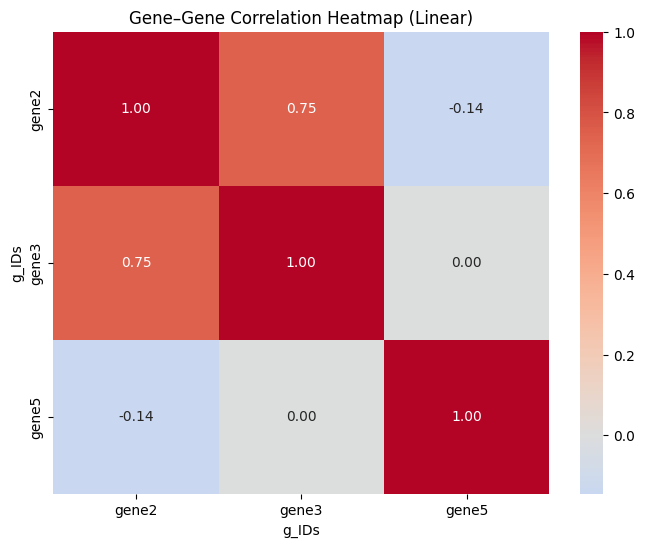

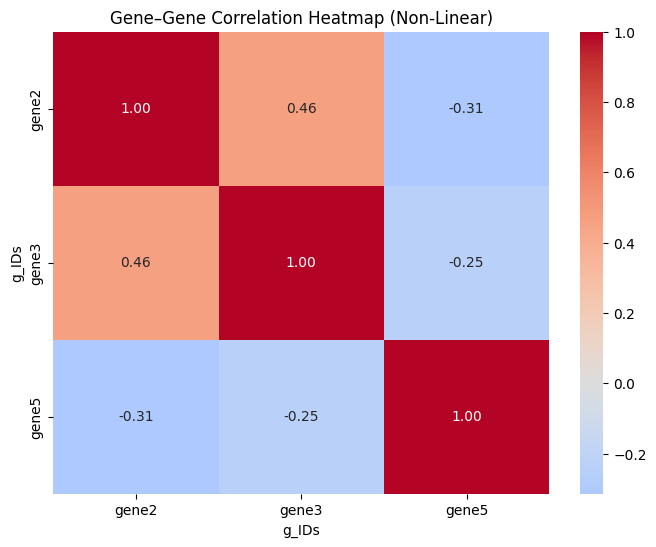

In [7]:
# visual check: heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Gene–Gene Correlation Heatmap (Linear)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Gene–Gene Correlation Heatmap (Non-Linear)")
plt.show()

In [8]:
# visual check: PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = df.loc[df.var(axis=1) > 1e-6] 
print("Data for PCA:")
print(data)

# expression_df: rows = genes, columns = samples
data_T = data.T  # now rows = samples, columns = genes
print("Transposed Data for PCA:")
print(data_T)


Data for PCA:
        s1NM   s2NM  s3NM   s4NM   s5NM   s6NM   s7DS   s8DS   s9DS  s10DS  \
g_IDs                                                                        
gene2  0.025  0.040  0.02  0.029  0.030  0.025  0.100  0.125  0.146  0.113   
gene3  1.000  1.000  0.25  1.000  1.000  0.906  0.000  0.000  0.003  0.001   
gene4  0.020  0.033  0.05  0.032  0.043  0.031  1.000  1.000  1.000  1.000   
gene5  0.500  0.833  1.00  0.799  1.000  1.000  0.009  0.005  0.007  0.008   

       s11DS  s12DS  
g_IDs                
gene2  0.106  0.121  
gene3  0.001  0.001  
gene4  1.000  1.000  
gene5  0.004  0.003  
Transposed Data for PCA:
g_IDs  gene2  gene3  gene4  gene5
s1NM   0.025  1.000  0.020  0.500
s2NM   0.040  1.000  0.033  0.833
s3NM   0.020  0.250  0.050  1.000
s4NM   0.029  1.000  0.032  0.799
s5NM   0.030  1.000  0.043  1.000
s6NM   0.025  0.906  0.031  1.000
s7DS   0.100  0.000  1.000  0.009
s8DS   0.125  0.000  1.000  0.005
s9DS   0.146  0.003  1.000  0.007
s10DS  0.113  0.001 

In [9]:
# Define a function to assign group based on column names
def assign_group(sample_name):
    if 'DS' in sample_name:
        return 'Disease'
    elif 'NM' in sample_name:
        return 'Normal'
    else:
        return 'Unknown'
# Apply to all sample names (index after transpose)
groups = [assign_group(s) for s in data_T.index]
print(groups)

['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Disease', 'Disease', 'Disease', 'Disease', 'Disease', 'Disease']


In [10]:
# Initialize PCA (2 components for a 2D plot)
pca = PCA(n_components=2)

# Fit PCA to the data
pca_result = pca.fit_transform(data_T)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=data_T.index)

# annotation
pca_df['Group'] = groups
print("PCA Result DataFrame:")
print(pca_df)

PCA Result DataFrame:
            PC1       PC2    Group
s1NM  -0.670850  0.313858   Normal
s2NM  -0.842810  0.107062   Normal
s3NM  -0.495439 -0.567687   Normal
s4NM  -0.825591  0.127954   Normal
s5NM  -0.927913  0.003379   Normal
s6NM  -0.881811 -0.070262   Normal
s7DS   0.771960  0.011103  Disease
s8DS   0.775553  0.014335  Disease
s9DS   0.773946  0.015971  Disease
s10DS  0.772670  0.012868  Disease
s11DS  0.774444  0.015179  Disease
s12DS  0.775840  0.016239  Disease


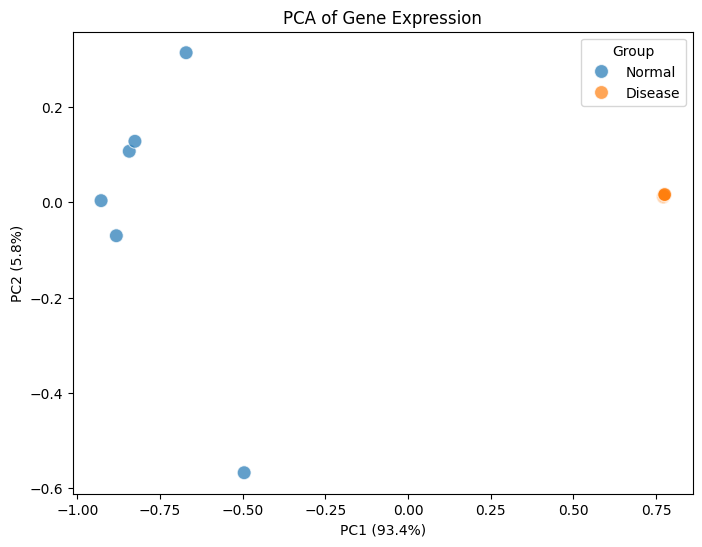

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, s=100, alpha=0.7)  # added alpha
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Gene Expression")
plt.legend(title='Group')
plt.show()

## Output and Visualization

### Part 1: Net graph

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Example transition matrix
data = {
    "GeneA": [0.0, 0.5, 0.2, 0.1, 0.05, 0.0, 0.0],
    "GeneB": [0.5, 0.0, 0.5, 0.2, 0.1, 0.1, -0.3],
    "GeneC": [0.2, 0.5, 0.0, 0.4, -0.2, -0.1, 0.3],
    "GeneD": [0.1, 0.2, 0.4, 0.0, 0.2, 0.2, 0.0],
    "GeneE": [0.05, 0.1, -0.2, 0.2, 0.0, 0.3, 0.25],
    "GeneF": [0.0, 0.1, -0.1, 0.2, 0.3, 0.0, 0.0],
    "GeneG": [0.0, -0.3, 0.3, 0.0, 0.25, 0.0, 0.0]
}

transition_df = pd.DataFrame(data, index=["GeneA", "GeneB", "GeneC", "GeneD","GeneE","GeneF","GeneG"])


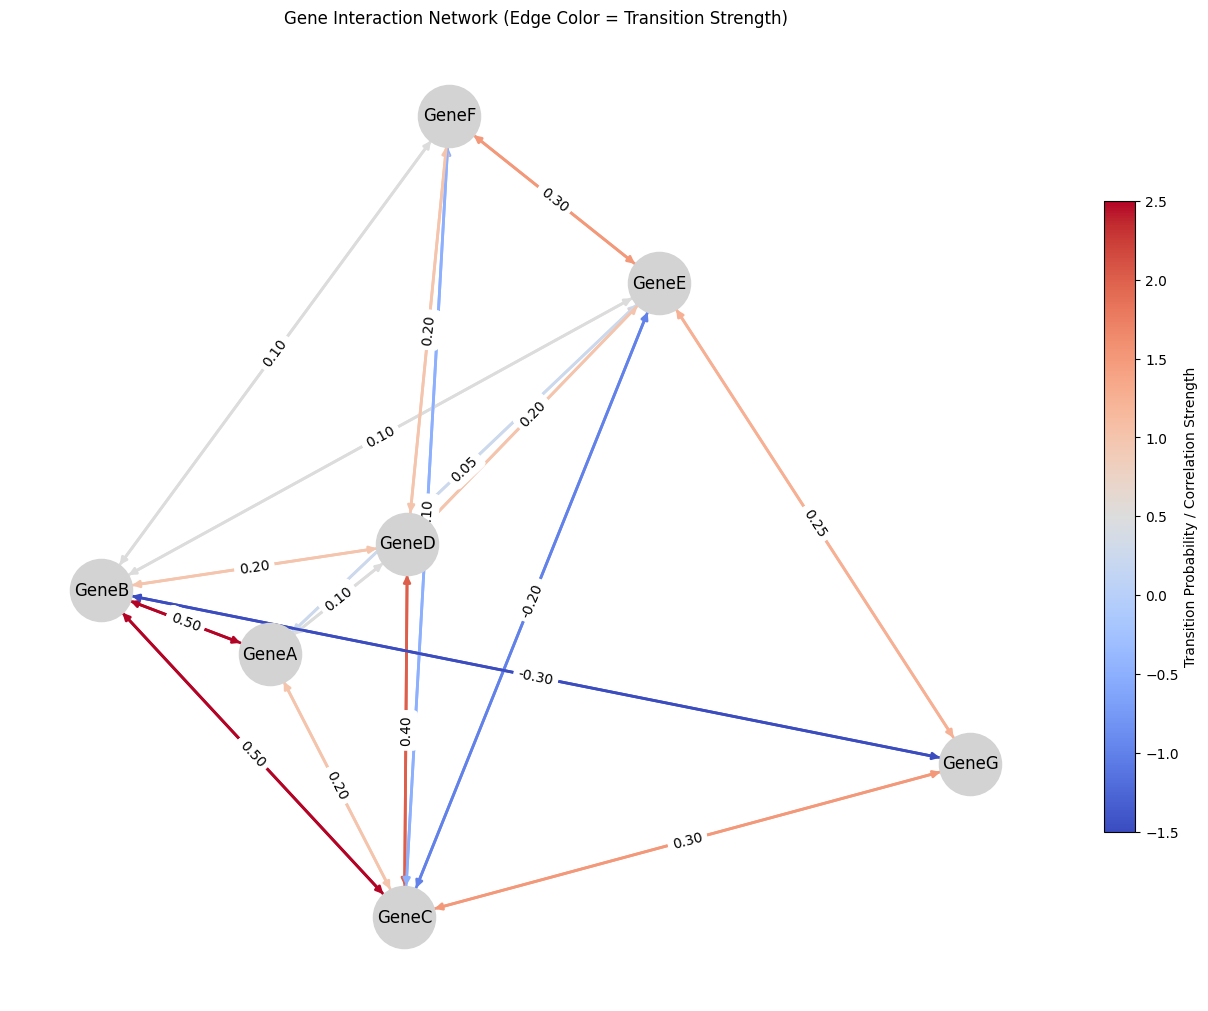

In [13]:
G = nx.DiGraph()

# Add edges with weights (probabilities)
for from_gene in transition_df.index:
    for to_gene in transition_df.columns:
        weight = transition_df.loc[from_gene, to_gene]
        if abs(weight) > 0:
            G.add_edge(from_gene, to_gene, weight=weight)

# Define layout (spring_layout or circular_layout)
pos = nx.spring_layout(G, seed=42)

# Get edge weights
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # scale up for visibility

cmap = plt.cm.coolwarm

# Normalize weights between 0 and 1 for colormap scaling
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
edge_colors = [cmap(norm(w)) for w in weights]

fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="lightgrey",
    edge_color=edge_colors,
    width=2,
    font_size=12,
    arrows=True,
    ax=ax
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Transition Probability / Correlation Strength")

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black", font_size=10, ax=ax)

plt.title("Gene Interaction Network (Edge Color = Transition Strength)")
plt.show()